# Proyecto de Clasificación
Para este proyecto trabajarán con el dataset
[Heart Failure Prediction - Clinical Records](https://www.kaggle.com/datasets/aadarshvelu/heart-failure-prediction-clinical-records).
Toda la información sobre el dataset la pueden encontrar en el link. Aprender a
leer la información y entender cómo está construido un dataset es un *skill* muy
importante, que deben desarrollar.

Por otro lado, recuerden que Kaggle tiene una pestaña `Code`, donde pueden
inspeccionar código de otras personas; siéntanse libres de hacerlo, ese es otro
skill importante y es la forma en la que la mayoría de la gente en el campo
aprende sobre nuevos modelos y se mantiene actualizada.

Su proyecto deberá incluir:
- Descarga e importación del Dataset
- EDA: justificar por qué decidieron utilizar sus métodos de visualización,
además de proporcionar alguna breve conclusión que obtengan a partir de su
análisis de los datos
- Metodos de validación: Hold-out y k-fold
- Preproceso: justificar las operaciones realizadas
- Entrenamiento de modelos:
    - [kNN](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)
    - [Regresión Logística](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)
    - [Árboles de Decisión](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html)
    - [Random Forest](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)
    - [Support Vector Machines](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html). **Recurso:** [Support Vector Machines](https://www.analyticsvidhya.com/blog/2021/10/support-vector-machinessvm-a-complete-guide-for-beginners/)
    - Deberán trabajar con al menos dos modelos de los vistos en clase; el uso de
    SVM es **obligatorio**, investigar sobre un método nuevo y animarse a
    utilizar las implementaciones es, quizás, el *skill* más preciado que puedan
    desarrollar.
- Prueba y Desempeño del modelo
- Conclusiones


## Imports y variables globales

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

SEED = 73
np.random.seed(SEED)

file_path = 'heart_failure_clinical_records_dataset.csv'

In [3]:
# import data as array
ds_arr = np.loadtxt(file_path, delimiter=',', skiprows=1)

# import data as pandas dataframe  
ds_df = pd.read_csv(file_path)

ds_df

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,55.0,0,748,0,45,0,263358.03,1.3,137,1,1,88,0
1,65.0,0,56,0,25,0,305000.00,5.0,130,1,0,207,0
2,45.0,0,582,1,38,0,319000.00,0.9,140,0,0,244,0
3,60.0,1,754,1,40,1,328000.00,1.2,126,1,0,90,0
4,95.0,1,582,0,30,0,461000.00,2.0,132,1,0,50,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,45.0,0,582,1,55,0,543000.00,1.0,132,0,0,250,0
4996,60.0,1,582,0,30,1,127000.00,0.9,145,0,0,95,0
4997,95.0,1,112,0,40,1,196000.00,1.0,138,0,0,24,1
4998,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


## EDA
- ¿Mi banco de datos es balanceado?, ¿Cómo puedo saberlo?
- ¿Qué otras visualizaciones puedo realizar para analizar mis datos?

### Descripción de los datos

Se obtienen algunas estadíticas del conjunto de datos, y se decide describir si los valores son **discretos** o **continuos**; si el número de valores únicos encontrados en cada columna es menor a **10**, se categoriza como valor **discreto**.

In [4]:
columns = ds_df.keys()

ds_desc = ds_df.describe().T
ds_desc.insert(1, 'values_type', None)
ds_desc.insert(2, 'unique_val_cnt', None)
ds_desc.insert(3, 'unique_values', None)


for column in columns:
    col_unique_data = ds_df[column].unique()
    col_unique_data.sort()
    col_type = 'continuous' if col_unique_data.size > 10  else 'discrete'

    ds_desc.at[column, 'values_type'] = col_type
    ds_desc.at[column, 'unique_val_cnt'] = col_unique_data.size
    ds_desc.at[column, 'unique_values'] = col_unique_data

# Exclude last column as it is the target
disc_cols = ds_desc.loc[ds_desc['values_type'] == 'discrete'][:-1]
cont_cols = ds_desc.loc[ds_desc['values_type'] == 'continuous']

ds_desc

,count,values_type,unique_val_cnt,unique_values,mean,std,min,25%,50%,75%,max
age,5000.0,continuous,48,"[40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47....",60.288736,11.697243,40.0,50.0,60.00,68.0,95.0
anaemia,5000.0,discrete,2,"[0, 1]",0.474400,0.499394,0.0,0.0,0.00,1.0,1.0
creatinine_phosphokinase,5000.0,continuous,290,"[23, 25, 26, 30, 31, 34, 44, 47, 52, 53, 54, 5...",586.760600,976.733979,23.0,121.0,248.00,582.0,7861.0
diabetes,5000.0,discrete,2,"[0, 1]",0.439400,0.496364,0.0,0.0,0.00,1.0,1.0
ejection_fraction,5000.0,continuous,17,"[14, 15, 17, 20, 25, 30, 35, 38, 40, 45, 50, 5...",37.734600,11.514855,14.0,30.0,38.00,45.0,80.0
high_blood_pressure,5000.0,discrete,2,"[0, 1]",0.364800,0.481422,0.0,0.0,0.00,1.0,1.0
platelets,5000.0,continuous,203,"[25100.0, 26000.0, 26500.0, 27000.0, 27100.0, ...",265075.404370,97999.758622,25100.0,215000.0,263358.03,310000.0,850000.0
serum_creatinine,5000.0,continuous,43,"[0.5, 0.6, 0.7, 0.75, 0.8, 0.85, 0.9, 1.0, 1.0...",1.369106,1.009750,0.5,0.9,1.10,1.4,9.4
serum_sodium,5000.0,continuous,27,"[113, 116, 121, 124, 125, 126, 127, 128, 129, ...",136.808200,4.464236,113.0,134.0,137.00,140.0,148.0
sex,5000.0,discrete,2,"[0, 1]",0.645600,0.478379,0.0,0.0,1.00,1.0,1.0


### Balanceo de clases

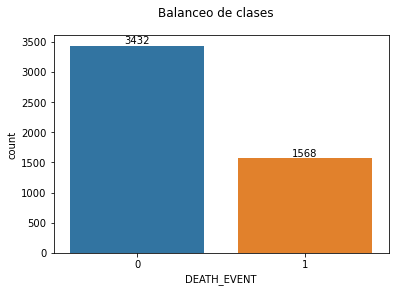

In [48]:
fig, ax = plt.subplots()

ax = sns.countplot(ds_df, x='DEATH_EVENT')

fig.suptitle('Balanceo de clases')
ax.bar_label(ax.containers[0])

plt.show()

### Visualización de datos discretos

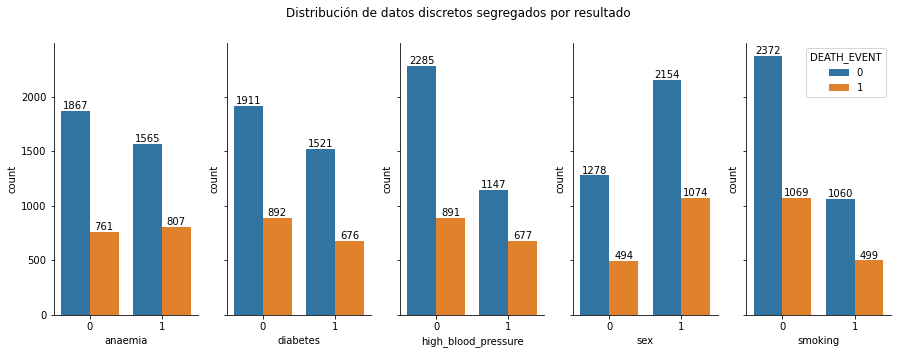

In [49]:
fig, axes = plt.subplots(ncols=disc_cols.index.values.size, sharey=True, figsize=(15,5))

idx = 0

for col in disc_cols.index:
    ax = axes[idx]
    sns.countplot(ds_df,
                  x=col,
                  hue='DEATH_EVENT',
                  ax=ax)

    if idx < axes.size - 1:
        ax.get_legend().remove()

    ax.spines[['right', 'top']].set_visible(False)
    ax.bar_label(ax.containers[0])
    ax.bar_label(ax.containers[1])
    
    idx = idx + 1

fig.suptitle('Distribución de datos discretos segregados por resultado')

plt.show()

### Visualización de datos continuos

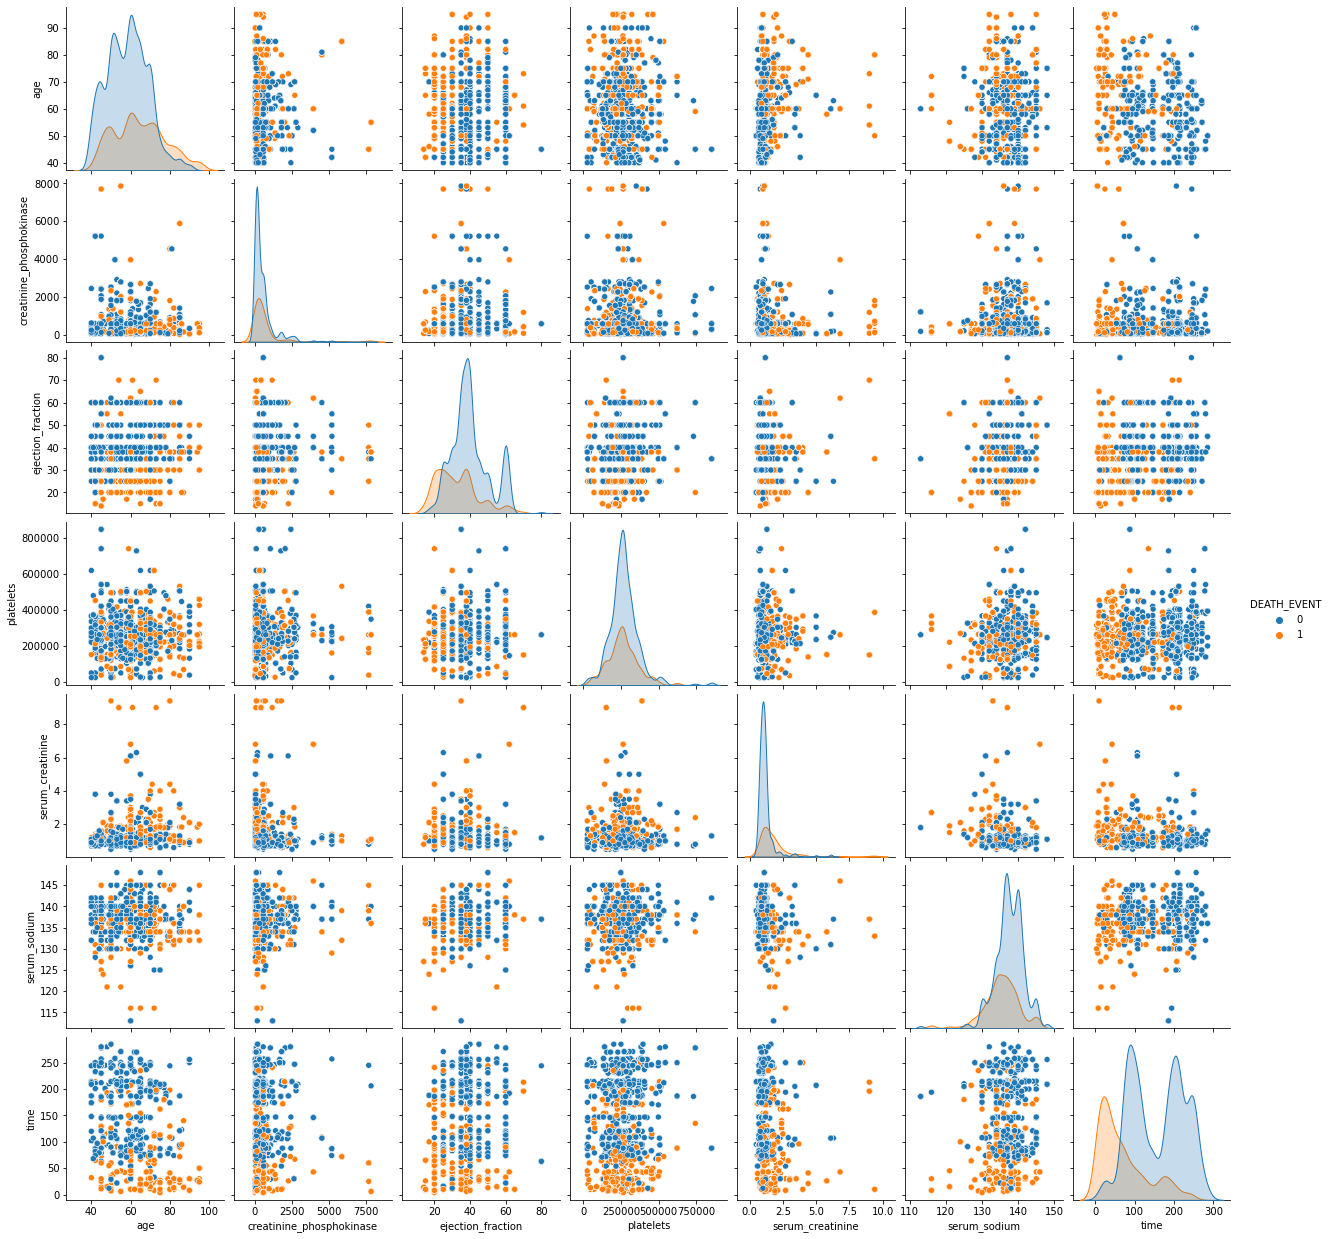

In [274]:
sns.pairplot(ds_df,
             hue='DEATH_EVENT',
             diag_kind='kde',
             vars=cont_cols.index)

plt.show()

### Correlación de datos

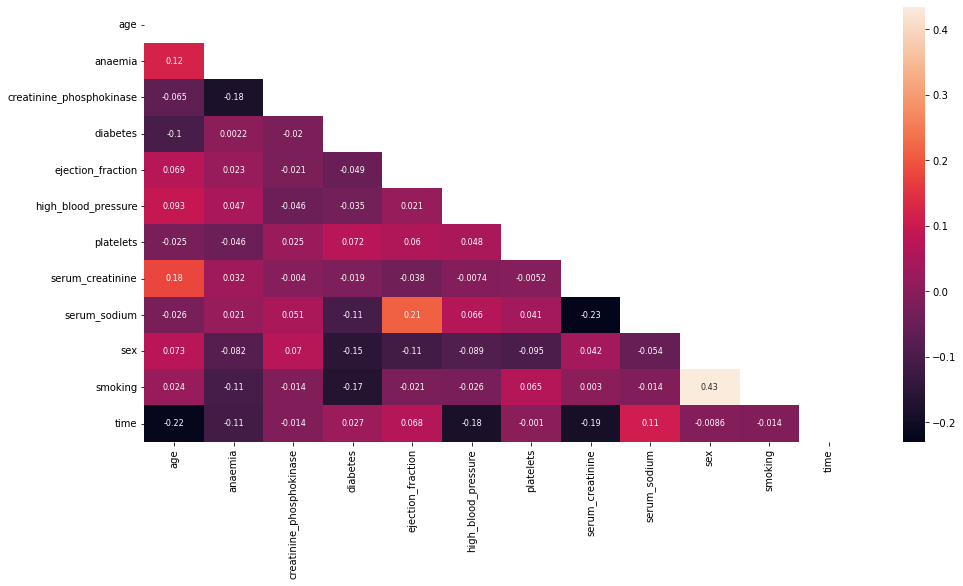

In [50]:
# print(ds_df.drop(columns=['DEATH_EVENT']).corr())
plt.figure(figsize=(16,8))

ds_corr = ds_df.drop(columns=['DEATH_EVENT']).corr()

sns.heatmap(ds_corr,
            annot=True,
            annot_kws={'size': 8,},
            mask=np.triu(np.ones_like(ds_corr.transpose())))

plt.show()

## Validación
Utilizar Hold-out y k-fold. En caso de que el dataset sea desbalanceado, debemos
de asegurar, en la medida de lo posible, que nuestras particiones respetarán la
distribución de nuestros datos, el término `stratified` en `sklearn` hace
referencia a este proceso.

- [hold-out](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html). Si el dataset es desbalanceado, deberán utilizar el
parámetro `stratify`.
- [k-fold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html)
- [Stratified k-fold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html#sklearn.model_selection.StratifiedKFold)

**Nota**: Recuerda que hold-out se ejecuta una sola vez, mientras que kfold se
ejecuta k número de veces (requieres un ciclo `for` para ello)

## Preproceso
- ¿Qué transformaciones debería hacer a mis datos?

## Entrenamiento del modelo
Utilizar al menos dos algoritmos de clase, además del clasificador de Máquinas
de Soporte Vectorial.

## Prueba y desempeño del modelo
Para problemas balanceados, ya vimos como se prueba y se mide el desempeño del
modelo para ambos métodos de validación. Aunque `accuracy` es la métrica
predilecta, nada impide, si así lo desean, que calculen alguna otra métrica que
surja a partir de la matriz de confusión.

En el caso de datasets desbalanceados, lo primero que deben de recordar es que
`accuracy` **no es una métrica válida**, por lo que debemos recurrir a alguna
otra métrica y a nuestra `matriz de confusión`. Para el caso de `hold-out`,
basta con calcular el desempeño del modelo una vez ha sido entrenado y puesto a
prueba. Sin embargo, en el caso de `k-fold`, no podemos calcular las métricas
de desempeño del modelo en cada fold y luego promediar (cosa que hacemos cuando
es balanceado y calculamos accuracy); debemos almacenar todas las predicciones y
las ground truth de todos los folds (**conservando el orden en que fueron
presentados al modelo**), y una vez que terminamos con los folds, debemos
calcular la métrica de manera global.




A continuación se les proporciona un repaso de
[la matriz de confusión y métricas de desempeño](https://www.analyticsvidhya.com/blog/2021/07/metrics-to-evaluate-your-classification-model-to-take-the-right-decisions/).

Las métricas ya forman parte de `sklearn`:
- [Accuracy](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html)
- [Balanced Accuracy](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.balanced_accuracy_score.html)
- [Recall (sensitivity)](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.recall_score.html)
- [Precision](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_score.html)
- [F1](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html)


Veamos un caso de `k-fold` con datos desbalanceados y calculo de diferentes
métricas. Solo crearemos un vector síntetico de ground truth, y en cada fold
crearemos un vector de *predicciones* de manera aleatoria.

In [ ]:
from sklearn.metrics import accuracy_score, recall_score, f1_score, \
                            balanced_accuracy_score, precision_score
                            
from sklearn.model_selection import StratifiedKFold
n_splits = 10
kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=73)

ones_ = np.ones((15,), dtype=int)
zeros_ = np.zeros((85,), dtype=int)
y = np.concatenate((ones_, zeros_))

balanced_accuracy_avg = 0
f1_avg = 0
recall_avg = 0
y_preds = []  # para guardar las predicciones de cada fold
ys = []  # para guardar los valores reales de y de cada fold
for train_index, test_index in kf.split(y, y):
    """
    para el vector y_pred, solo hagamos de cuenta que son las predicciones de un
    modelo ya entrenado.
    """
    y_test = y[test_index]
    y_pred = np.random.randint(0, 2, y_test.shape[0])

    balanced_accuracy_avg += balanced_accuracy_score(y_test, y_pred)
    f1_avg += f1_score(y_test, y_pred)
    recall_avg += recall_score(y_test, y_pred)

    y_preds += list(y_pred)
    ys += list(y_test)

print(10*'-' + ' Resultados ' + 10*'-')
print(f"Balanced accuracy avg: {balanced_accuracy_avg/n_splits}")
print(f"Balanced accuracy global: {balanced_accuracy_score(ys, y_preds)}")
print()
print(f"F1 avg: {f1_avg/n_splits}")
print(f"F1 global: {f1_score(ys, y_preds)}")
print()
print(f"Recall avg: {recall_avg/n_splits}")
print(f"Recall global: {recall_score(ys, y_preds)}")

## Matriz de Confusión
- [Matriz de confusión](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html)

In [ ]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(ys, y_preds))

In [ ]:
# podemos guardar en variables los resultados de cada casi de la matriz
tn, fp, fn, tp = confusion_matrix(ys, y_preds).ravel()

# a partir de estos valores podemos calcular las métricas que queramos a mano
# si asi lo deseamos

# recall
recall_own = tp / (tp + fn)
recall_sk = recall_score(ys, y_preds)
print(f"Recall own: {recall_own}")
print(f"Recall sk: {recall_sk}")
print(f"Recall own == Recall sk: {recall_own == recall_sk}")
print()

# precision
precision_own = tp / (tp + fp)
precision_sk = precision_score(ys, y_preds)
print(f"Precision own: {precision_own}")
print(f"Precision sk: {precision_sk}")
print(f"Precision own == Recall sk: {precision_own == precision_sk}")
print()

# specificity no está programa, pero es un recall de la clase 0
specificity_own = tn / (tn + fp)
specificity_sk = recall_score(ys, y_preds, pos_label=0)
print(f"Specificity own: {specificity_own}")
print(f"Specificity sk: {specificity_sk}")
print(f"Specificity own == Recall sk: {specificity_own == specificity_sk}")
print()

# balanced accuracy
balanced_accuracy_own = (recall_own + specificity_own) / 2
balanced_accuracy_sk = balanced_accuracy_score(ys, y_preds)
print(f"Recall own: {balanced_accuracy_own}")
print(f"Recall sk: {balanced_accuracy_sk}")
print(f"Recall own == Recall sk: {balanced_accuracy_own == balanced_accuracy_sk}")
print()

También podemos visualizar mediante una gráfica de heatmap a nuestra matriz de
confusión. La ventaja de esta gráfica es que nos mostrará cada casilla de
nuestra matriz con un color que va de acuerdo con el valor que tiene dicha
casilla:
- entre más oscura sea la celda, mayor número de patrones caen en esa casilla
- entre más clas sea, menos patrones encontramos ahí

Una buena matriz de confusión es aquella para la cual su diagonal principal
presenta colores oscuros y fuera de ella colores claros, mostrando así muchos
aciertos (diagonal) y pocos errores (fuera de diagonal).

Caso contrario, si llegamos a encontrar una casilla oscura fuera de la diagonal
quiere decir que nuestro modelo está cometiendo muchos errores.

Grafiquemos la matriz de confusión de nuestros datos sintéticos, y observemos
que esta es una matriz no ideal.

In [ ]:
cm = confusion_matrix(ys, y_preds)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

Ahora visualicemos una matriz de confusión *optima* y una deficiente, para más
clases

In [ ]:
cm = np.array([[48, 1, 1],
               [1, 47, 2],
               [2, 2, 46]])

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix Optima')
plt.show()


cm = np.array([[31, 14, 5],
               [31, 5, 14],
               [20, 20, 10]])

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix Optima')
plt.show()

La ventaja de visualizar de esta manera la matriz de confusión es que podemos
guiarnos únicamente por la escala de colores, sin tener que analizar a detalle
los valores numéricos.

Poder analizar la matriz de confusión mediante la escala de colores nos permite
tener un *feeling* prácticamente instantáneo del desempeño del modelo; este
*skill* es invaluable y, en definitiva, uno que les conviene desarrollar con la
práctica.

## Conclusiones